In [1]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from score_query import ScoreQuery
from utils import export, show_side_by_side, load_score_file
from statistics import *
from prob_opt import LigSet, PredictStructs

sys.path.append('../1_dock')
from parse_chembl import load_chembl_raw, load_chembl_proc
from core_proc import load_matches

In [2]:
data = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp1'
mcss_dir = 'mcss/mcss1'

struct_dict = {'AR':'2PNU','A2AR':'2YDO','B1AR':'2VT4','B2AR':'2RH1','CHK1':'2BRN', 'PLK1':'2OWB',
               'VITD':'2HB7','BRAF':'3IDP','JAK2':'3KRR','CDK2':'1H1S','ERA':'1A52','GCR':'3K23'}

features = {
    'mcss':[],
    'hbond':[2,3],
    'sb':[4],
    'pipi':[6],
    'contact':[11]
}

B1AR
warning, only 10 ligands found for B1AR
sb


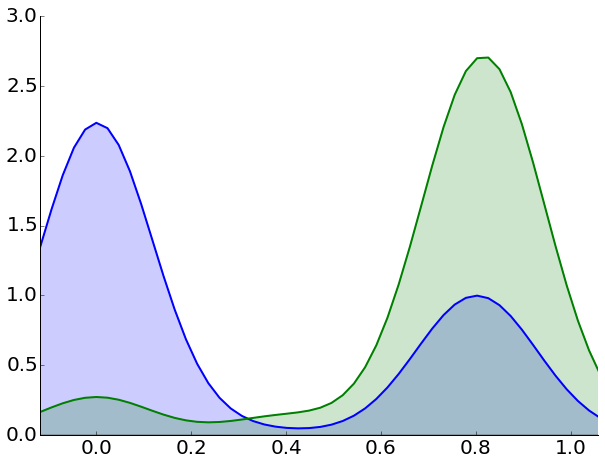

mcss


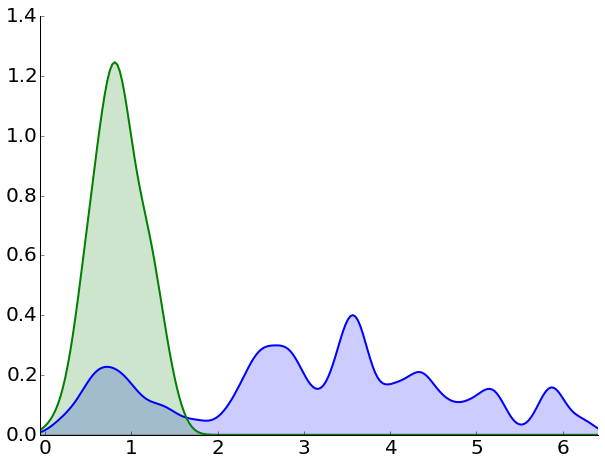

contact


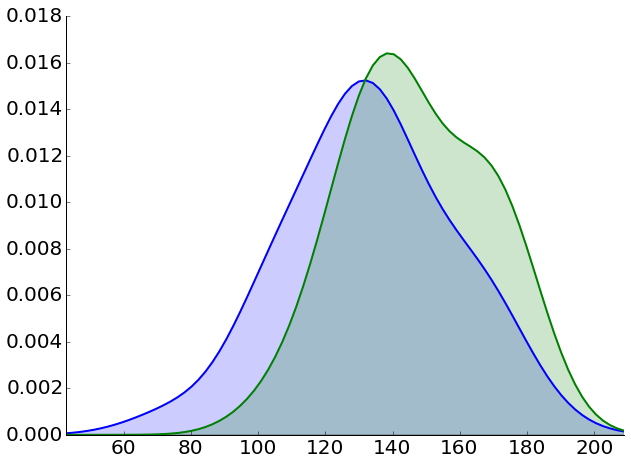

pipi


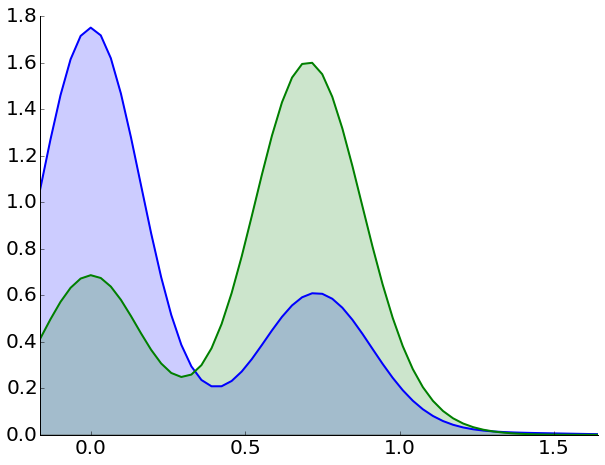

hbond


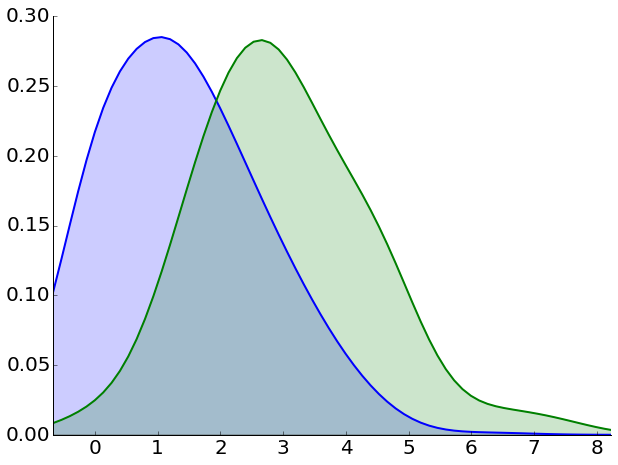

AR
warning, only 16 ligands found for AR
sb
mcss


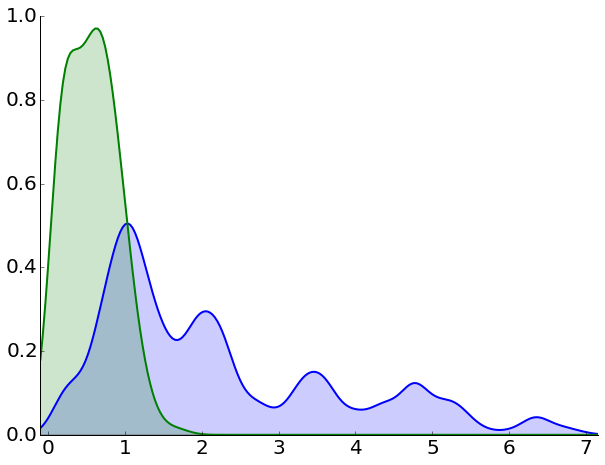

contact


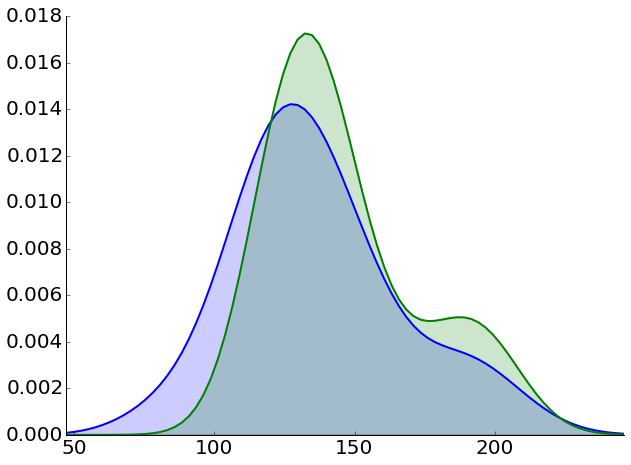

pipi


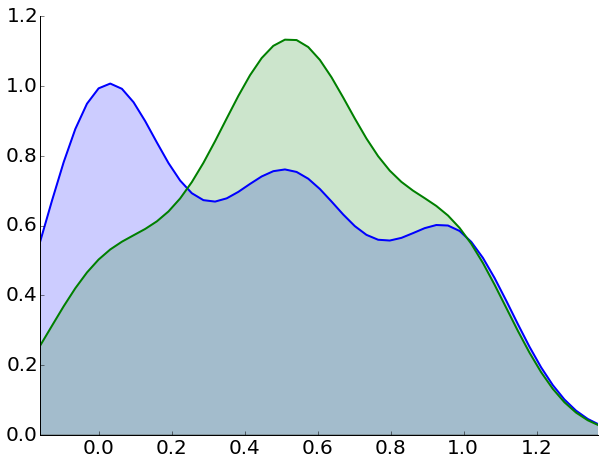

hbond


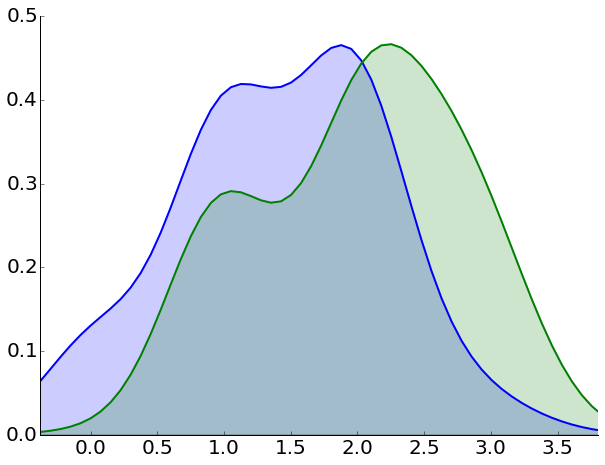

CHK1
sb
mcss


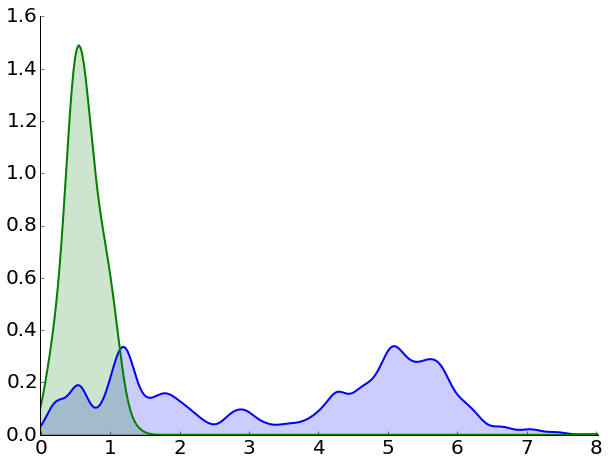

contact


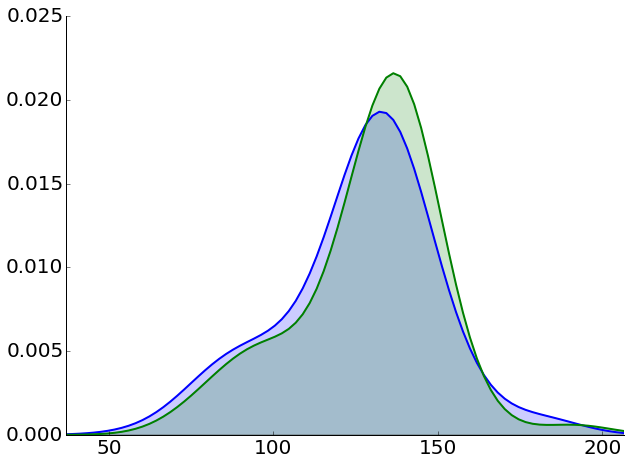

pipi


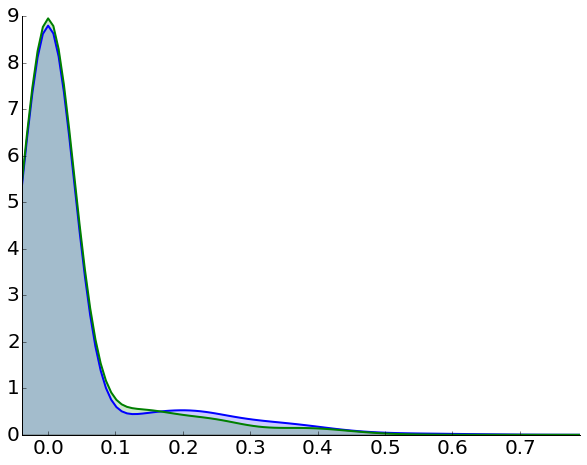

hbond


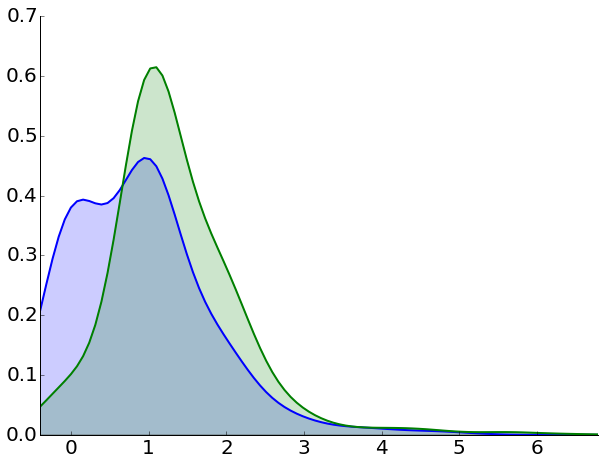

In [10]:
stats_prots = ['CHK1']

num_poses = 25
for p in ['B1AR','AR','CHK1']:#struct_dict:
    # update containers to not load docking results not in ligands/unique ...
    #if p == 'ERA': continue
    print p
    stats_prots = [p]
    predict_prots = stats_prots#['B1AR']

    load_prots = list(set(stats_prots + predict_prots))

    all_data = Dataset(data, load_prots)

    all_data.load_docking(glide_dir, ifp_dir, mcss_dir, structs=struct_dict,
                          load_fp=True, load_crystal=False, load_chembl=False, load_mcss=True)
    
    stats = Statistics(all_data, stats_prots, 20, 25, features)
    
    for f_name in features.keys():
        print f_name
        stats.show_stats(f_name, raw=False, smoothed=True)
        #stats.show_stats_by_pair(f_name, raw=False, smoothed=True)
    continue
    for s, st in all_data.proteins[p].docking.items():

        print p, s
        
        l_list = stats.proteins[p][:10]
        pred_ligs = {l:st.ligands[l] for l in l_list}

        ls = LigSet(pred_ligs, num_poses, features, st.mcss, t=10)
        
        ps = PredictStructs(ls, stats.evidence, features)
        best_cluster, en_landscape = ps.max_posterior(verbose=True, sampling=1, en_landscape=True)
        
        ps2 = PredictStructs(ls, stats.evidence, {})
        best_cluster2, en_landscape2 = ps2.max_posterior(verbose=True, sampling=1, en_landscape=True)
        
        #ps.posterior(best_cluster, verbose=False)
        
        for l,p in ls.get_poses(best_cluster).items():
            print l, p.rank, p.rmsd, 0, ls.all_poses[l][0].rmsd
        print 'us rmsd:',np.mean([ls.all_poses[l][p].rmsd for l,p in best_cluster.items()])
        print 'phys rmsd:',np.mean([ls.all_poses[l][0].rmsd for l,p in best_cluster.items()])
        

In [ ]:
print len([x for x in en_landscape if x[1] is not None])

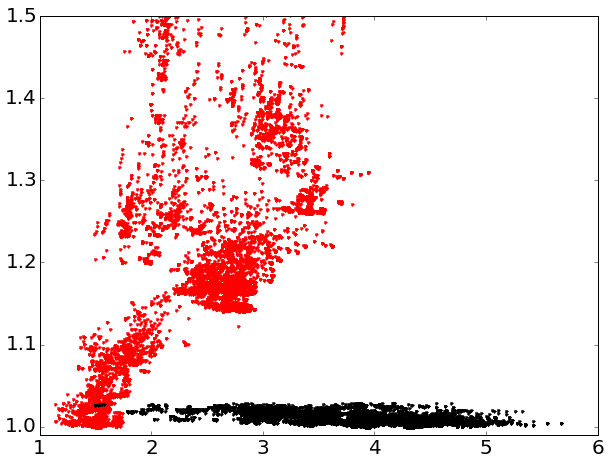

In [7]:
norm1 = max([x[0] for x in en_landscape])
objective = [x[0]/norm1 for x in en_landscape]
rmsds = [x[1] for x in en_landscape]

norm2 = max([x[0] for x in en_landscape2])
phys_obj = [x[0]/norm2 for x in en_landscape2]
rmsds2 = [x[1] for x in en_landscape2]
plt.plot(rmsds, objective, 'r.')
#plt.show()
plt.plot(rmsds2, phys_obj, 'k.')
#plt.show()

#plt.ylim([-1600,-700])
plt.ylim([0.99,1.5])
plt.show()

In [ ]:
stats = Statistics(all_data, stats_prots, 20, 25, features)

In [ ]:
print stats.proteins[stats_prots[0]]

In [ ]:
for f_name in ['mcss']:#features.keys():
    print f_name
    stats.show_stats(f_name, raw=False, smoothed=True)
    stats.show_stats_by_pair(f_name, raw=False, smoothed=True)

In [ ]:
num_poses = 25

for p in predict_prots:
    for s, st in all_data.proteins[p].docking.items():

        print p, s
        
        #l_list = ['2Y00_lig','3ZPQ_lig','3ZPR_lig','4AMI_lig','4AMJ_lig','5A8E_lig']
        #pred_ligs = {l:st.ligands[l] for l in l_list}
        pred_ligs = {l:lig for l,lig in st.ligands.items() if l[:6] != 'CHEMBL'}# and l.split('_')[0] != s}

        ls = LigSet(pred_ligs, num_poses, features, st.mcss, t=10)
        
        ps = PredictStructs(ls, stats.evidence, features)
        best_cluster = ps.max_posterior(verbose=True)
        
        #ps.posterior(best_cluster, verbose=False)
        
        for l,p in ls.get_poses(best_cluster).items():
            print l, p.rank, p.rmsd, 0, ls.all_poses[l][0].rmsd
        print 'us rmsd:',np.mean([ls.all_poses[l][p].rmsd for l,p in best_cluster.items()])
        print 'phys rmsd:',np.mean([ls.all_poses[l][0].rmsd for l,p in best_cluster.items()])

In [ ]:
%prun ps.max_posterior(verbose=True)